In [1]:
# -- SETUP

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [2]:
print(tf.__version__)

2.4.1


In [3]:
# -- Set data directory

data_dir = pathlib.Path("data")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1225


In [4]:
batch_size = 32
img_height = 640
img_width  = 480

In [5]:
# -- Define training & validation dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1225 files belonging to 11 classes.
Using 980 files for training.
Found 1225 files belonging to 11 classes.
Using 245 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['bin_cover', 'buoy_green', 'buoy_red', 'buoy_yellow', 'channel', 'object_dropoff', 'object_pickup', 'qual_gate', 'torpedo_cover', 'torpedo_hole', 'torpedo_target']


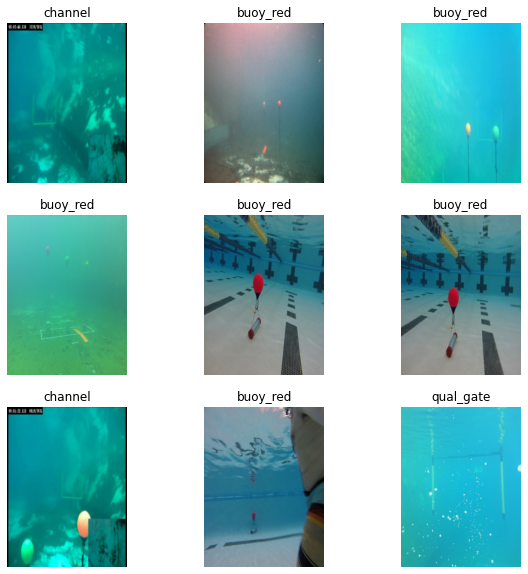

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
num_classes = 11

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [31]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
31/31 [==============================] - 103s 3s/step - loss: 1.6912 - accuracy: 0.5601 - val_loss: 0.7687 - val_accuracy: 0.7102
Epoch 2/3
31/31 [==============================] - 100s 3s/step - loss: 0.6864 - accuracy: 0.7573 - val_loss: 0.7481 - val_accuracy: 0.7347
Epoch 3/3
31/31 [==============================] - 100s 3s/step - loss: 0.5907 - accuracy: 0.7847 - val_loss: 1.1339 - val_accuracy: 0.7510


In [12]:
# OPTIONAL - LOAD PRE-MADE MODEL
model = tf.keras.models.load_model('savedmodel/my_model')

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 640, 480, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 638, 478, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 319, 239, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 317, 237, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 158, 118, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 156, 116, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 78, 58, 32)       

In [14]:
import keras

image1 = pathlib.Path("test/bouy_green_738.jpg")
image2 = pathlib.Path("test/bouy_green_1213.jpg")
image3 = pathlib.Path("test/bouy_green_1687.jpg")
image4 = pathlib.Path("test/bouy_yellow_639.jpg")

images = [image1, image2, image3, image4]

for image in images:
    img = keras.preprocessing.image.load_img(
        image, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

This image most likely belongs to qual_gate with a 96.52 percent confidence.
This image most likely belongs to buoy_red with a 76.74 percent confidence.
This image most likely belongs to buoy_green with a 27.50 percent confidence.
This image most likely belongs to buoy_red with a 97.17 percent confidence.
